In [1]:
%matplotlib inline

from __future__ import print_function, division

import datetime
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2 as pg
import scipy.stats as stats
import time

from datetime import datetime
from IPython.display import Markdown, display

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 12

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
# get connected to the database
connection = pg.connect("dbname=fitbit user=james")

In [4]:
# load in a postgres table as a dataframe
sql = "SELECT r_hr, date, jsonb_array_elements(hr) #>  \
        '{time}' AS time, jsonb_array_elements(hr ) #> \
        '{value}' AS value FROM heart_rate \
        WHERE date <= '2016-02-20' "

df = psql.read_sql(sql, connection)

In [5]:
df.head()

,r_hr,date,time,value
0,66,2015-12-26,00:00:00,63
1,66,2015-12-26,00:00:10,62
2,66,2015-12-26,00:00:25,62
3,66,2015-12-26,00:00:40,66
4,66,2015-12-26,00:00:50,65


In [6]:
print(type(df.date[0]), type(df.time[0]))

<type 'datetime.date'> <type 'unicode'>


In [7]:
%%timeit
df['time1'] = df['time'].map(lambda x: datetime.time(datetime.strptime(x, '%H:%M:%S')))

1 loop, best of 3: 21.3 s per loop


In [8]:
type(df['time1'][0])

datetime.time

In [9]:
%%timeit
df['time2'] = df.apply(lambda x: datetime.time(datetime.strptime(x['time'], '%H:%M:%S')), axis=1)

1 loop, best of 3: 26.1 s per loop


In [10]:
type(df['time2'][0])

datetime.time

In [11]:
df.head()

,r_hr,date,time,value,time1,time2
0,66,2015-12-26,00:00:00,63,00:00:00,00:00:00
1,66,2015-12-26,00:00:10,62,00:00:10,00:00:10
2,66,2015-12-26,00:00:25,62,00:00:25,00:00:25
3,66,2015-12-26,00:00:40,66,00:00:40,00:00:40
4,66,2015-12-26,00:00:50,65,00:00:50,00:00:50


In [12]:
df['time'] = df['time2']
del(df['time1'], df['time2'])

In [13]:
# Get a datetime object column from date and time
df['datetime'] = df.apply(lambda x: datetime.combine(x['date'], x['time']), axis=1)
del([df['date'], df['time']])
df.head()

,r_hr,value,datetime
0,66,63,2015-12-26 00:00:00
1,66,62,2015-12-26 00:00:10
2,66,62,2015-12-26 00:00:25
3,66,66,2015-12-26 00:00:40
4,66,65,2015-12-26 00:00:50


In [14]:
# Now lets make those timestamps the index
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)
del(df['datetime'])

In [15]:
df.head()

,r_hr,value
2015-12-26 00:00:00,66,63
2015-12-26 00:00:10,66,62
2015-12-26 00:00:25,66,62
2015-12-26 00:00:40,66,66
2015-12-26 00:00:50,66,65


### Check out the data

In [16]:
df['value'].describe()

count    481938.000000
mean         68.881221
std          15.154213
min          39.000000
25%          57.000000
50%          65.000000
75%          79.000000
max         180.000000
Name: value, dtype: float64

In [17]:
df['r_hr'].describe()

count    481938.000000
mean         56.751709
std           3.489116
min          51.000000
25%          54.000000
50%          56.000000
75%          59.000000
max          66.000000
Name: r_hr, dtype: float64

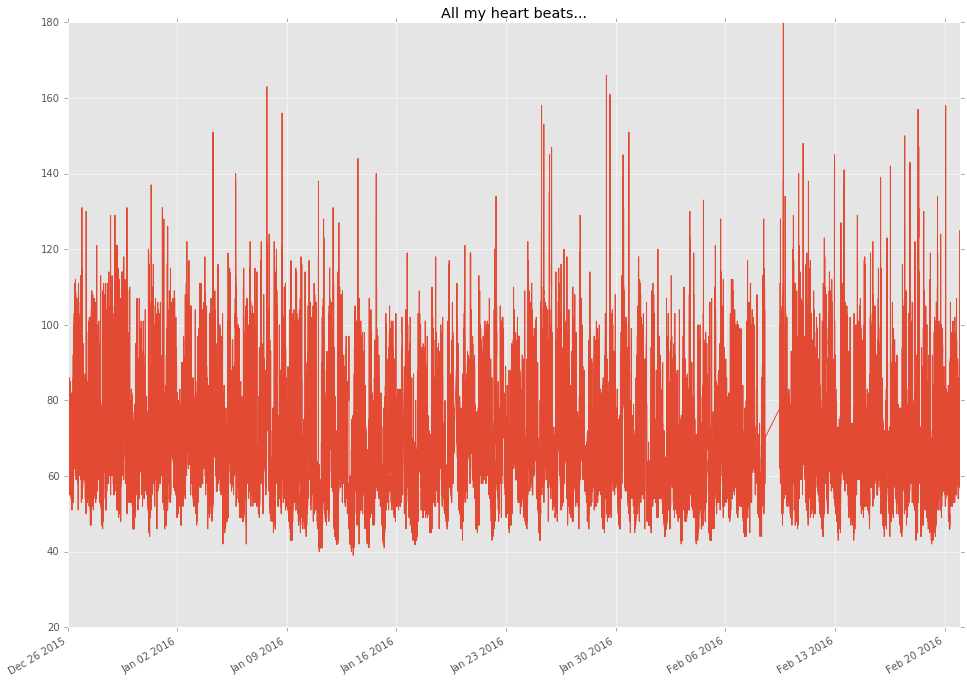

In [18]:
# Time series
df['value'].plot(title="All my heart beats...")

### It's a little bit messy...
Maybe aggregation will help.

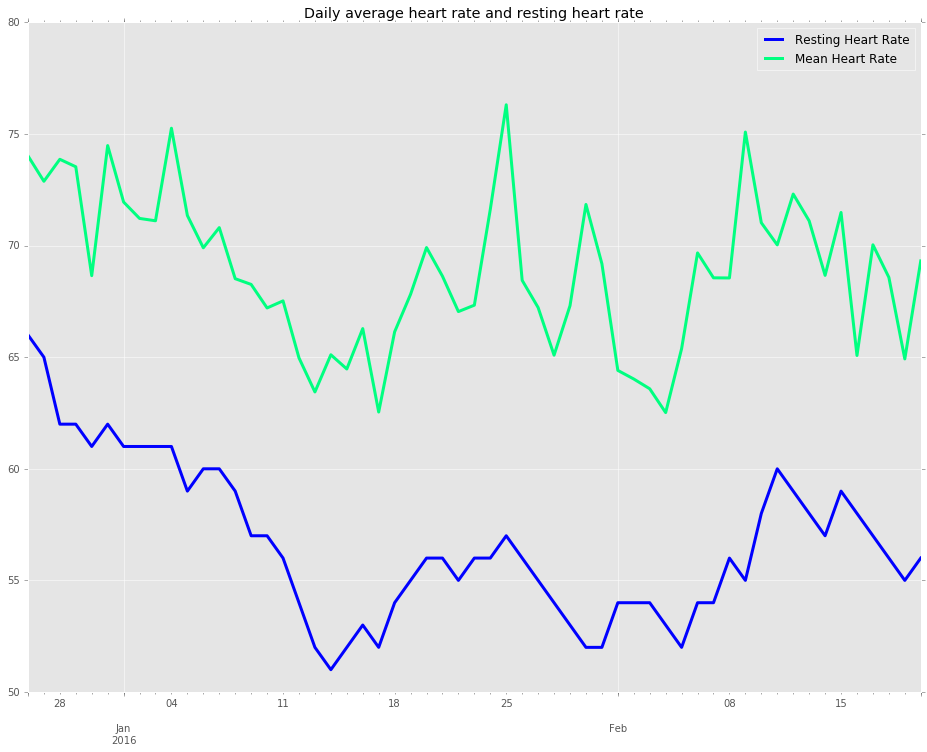

In [19]:
# Resample to day using mean
dfrsmpl = df.resample('D', how='mean')

dfrsmpl.plot(
    title="Daily average heart rate and resting heart rate",
    colormap='winter',
    lw=3)

plt.legend(labels=['Resting Heart Rate', 'Mean Heart Rate'])

### Much Better!

Let's check the distribution

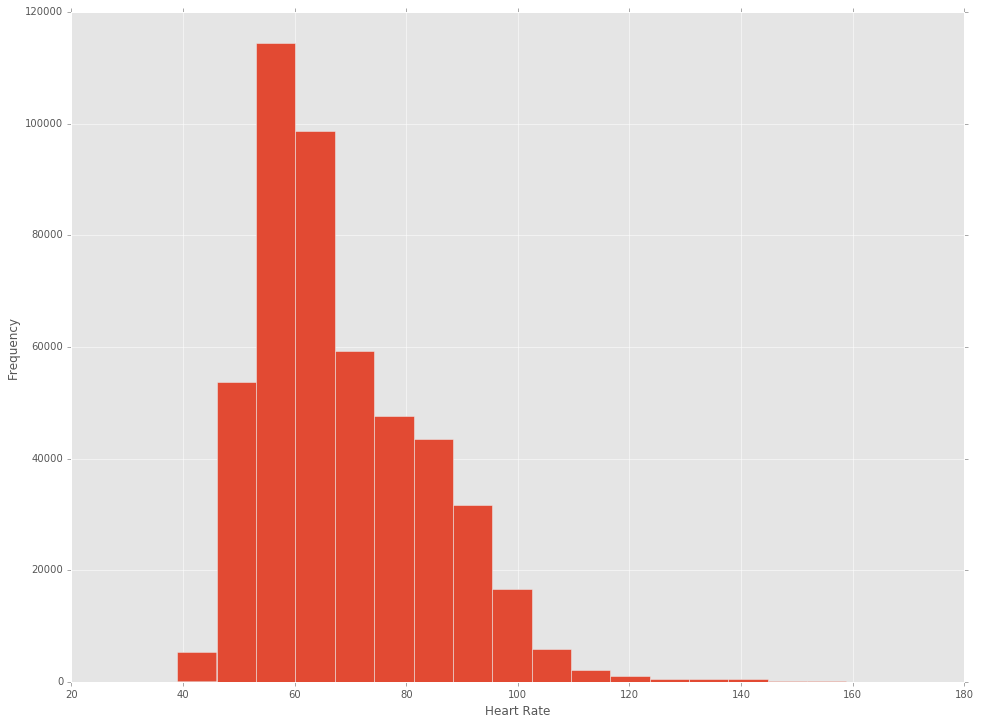

In [20]:
# Lets plot a histogram of the data
ax = df['value'].plot(kind="hist", bins=20)
ax.set_xlabel("Heart Rate")

### How do days of the week differ?

In [21]:
# List of days for label purposes
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# Index by the day of week. Monday = 0 Sunday = 6
dfdayofwk = df.set_index(df.index.dayofweek)

# Then group by the day of the week using the mean
grpdayofwk = dfdayofwk.groupby(dfdayofwk.index).mean()

In [22]:
# Lets take a look to check
grpdayofwk

,r_hr,value
0,57.456661,70.542957
1,56.858388,68.523445
2,56.614309,67.947243
3,56.596932,68.316851
4,55.798861,67.761636
5,57.066040,69.992247
6,56.854150,68.963509


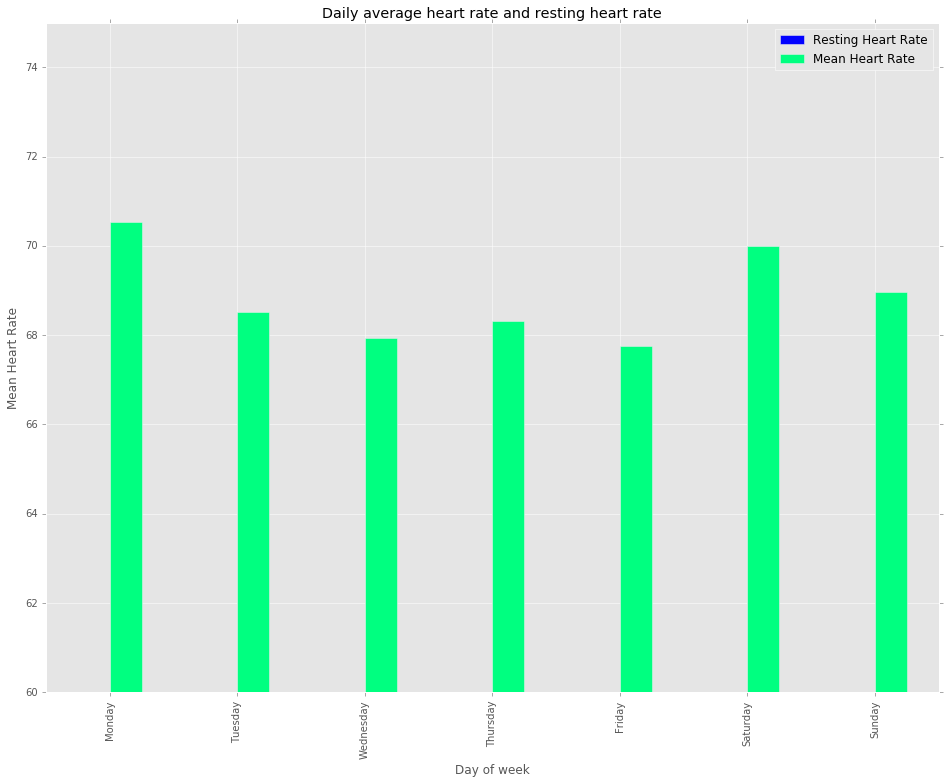

In [23]:
# Lets work on the ax object returned by Pandas.DataFrame.plot()
ax = grpdayofwk.plot(
    kind="bar",
    title="Daily average heart rate and resting heart rate",
    xlim=(0, 7),
    ylim=(60, 75),
    colormap='winter')

# It makes it easy to set custom params
ax.set_xticks(grpdayofwk.index)
ax.set_xticklabels(weekdays)
ax.set_xlabel("Day of week")
ax.set_ylabel("Mean Heart Rate")
ax.legend(labels=['Resting Heart Rate', 'Mean Heart Rate'])

### So Monday appears to be the day that my heart rate is highest on average.

We can check this for statistical difference

In [24]:
# Lets make all non-mondays a 1
dfdayofwk.index = dfdayofwk.index.map(lambda x: "other" if x > 0 else "monday")

In [25]:
# And check the new index
dfdayofwk.head()

,r_hr,value
other,66,63
other,66,62
other,66,62
other,66,66
other,66,65


In [26]:
# Lets check the number of days looks right
dfdayofwk.index.value_counts()

other     416535
monday     65403
dtype: int64

In [27]:
# Then group by the index
dfdayofwkgrpd = dfdayofwk.groupby(dfdayofwk.index).mean()
dfdayofwkgrpd

,r_hr,value
monday,57.456661,70.542957
other,56.641019,68.620301


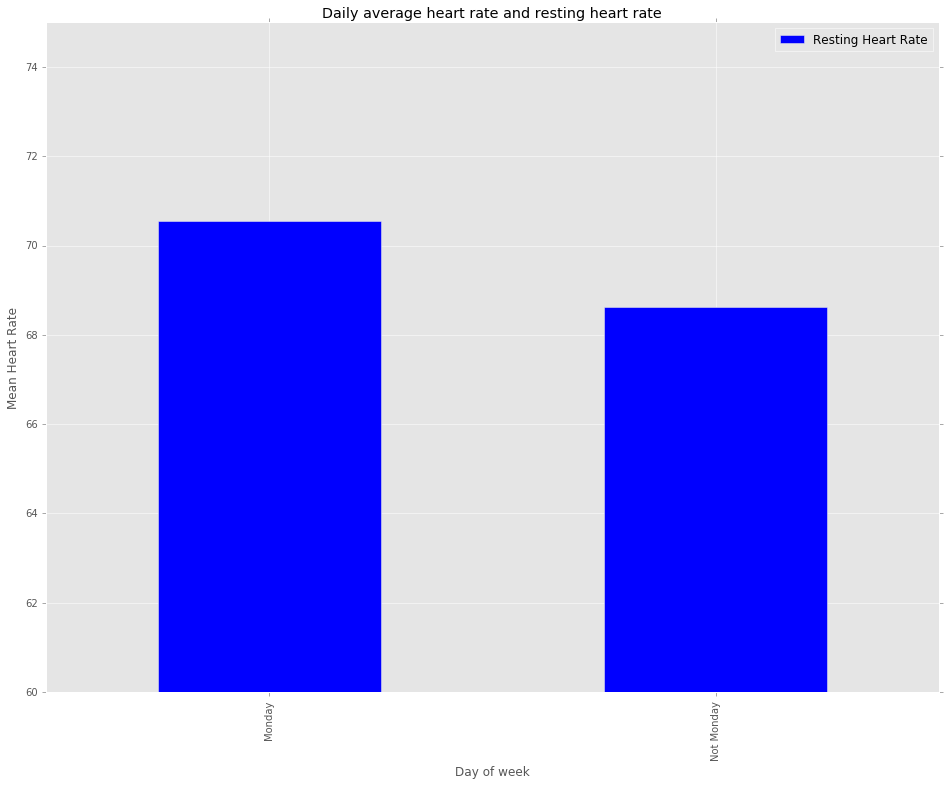

In [28]:
# We'll plot it agin to see if the difference is still there...
ax = dfdayofwkgrpd['value'].plot(
    kind="bar",
    title="Daily average heart rate and resting heart rate",
    xlim=(0, 1),
    ylim=(60, 75),
    colormap='winter')

# It makes it easy to set custom params
ax.set_xticks((0, 1))
ax.set_xticklabels(["Monday", "Not Monday"])
ax.set_xlabel("Day of week")
ax.set_ylabel("Mean Heart Rate")
ax.legend(labels=['Resting Heart Rate'])

In [29]:
# lets check this difference using stats
t, p = stats.ttest_ind(dfdayofwk['value'].loc['monday'], dfdayofwk['value'].loc['other'])

In [30]:
t, p

(30.19305796731139, 4.4980729728481912e-200)

In [31]:
def check_difference(t, p):
    # This was a two-sided t test
    # We can reject the null hypothesis of a greater
    # than test when p/2 < alpha and t > 0.
    # For this test, we use an alpha level of 0.05
    if p / 2 < 0.005 and t > 0:
        printmd('The mean __is__ significantly greater.')
    else:
        printmd('The mean is __not__ significantly greater.')

In [32]:
check_difference(t, p)

The mean __is__ significantly greater.

### But what about other weekdays?

In [33]:
def mondays_and_weekdays(x):
    if x == 0:
        return 0
    elif x > 0 and x <= 4:
        return 1
    else:
        return 2

In [34]:
# Index by the day of week. Monday = 0 Sunday = 6
dfdayofwk = df.set_index(df.index.dayofweek)

In [35]:
# Lets make all non-mondays a 1 and weekends a 2
dfdayofwk.index = dfdayofwk.index.map(mondays_and_weekdays)

In [36]:
dfdayofwk.index.value_counts()

1    267921
2    148614
0     65403
dtype: int64

In [37]:
# Then group by the index
dfdayofwkgrpd = dfdayofwk.groupby(dfdayofwk.index).mean()
dfdayofwkgrpd

,r_hr,value
0,57.456661,70.542957
1,56.460572,68.127821
2,56.966329,69.508142


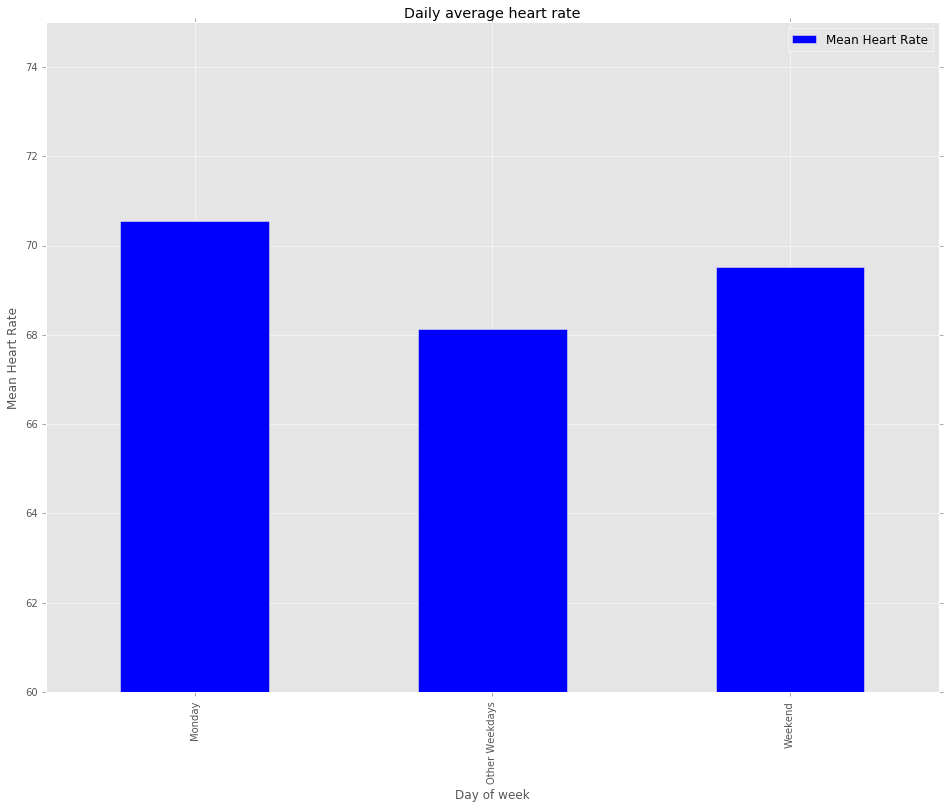

In [38]:
# We'll plot it agin to see if the difference is still there...
ax = dfdayofwkgrpd['value'].plot(
    kind="bar",
    title="Daily average heart rate",
    xlim=(0, 1),
    ylim=(60, 75),
    colormap='winter')

# It makes it easy to set custom params
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(["Monday", "Other Weekdays", "Weekend"])
ax.set_xlabel("Day of week")
ax.set_ylabel("Mean Heart Rate")
ax.legend(labels=['Mean Heart Rate'])

In [39]:
t, p = stats.ttest_ind(dfdayofwk['value'].ix[0], dfdayofwk['value'].ix[2], equal_var=False)

In [40]:
t, p

(13.445209694305113, 3.5461302563722031e-41)

In [41]:
check_difference(p, t)

The mean is __not__ significantly greater.

### And how about sub-daily patterns???

In [42]:
# remind ourselves what our data look like
df.head()

,r_hr,value
2015-12-26 00:00:00,66,63
2015-12-26 00:00:10,66,62
2015-12-26 00:00:25,66,62
2015-12-26 00:00:40,66,66
2015-12-26 00:00:50,66,65


In [43]:
# helper columns with hour and dow
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
# sum of counts for all combinations
df_g = df.groupby(['dow', 'hour']).mean()
# take the mean over all dates
df_g = df.reset_index().groupby(['dow', 'hour']).mean()

In [44]:
df_g

r_hr      value
dow hour                      
0   0     57.483412  62.071090
    1     57.477863  56.157634
    2     57.453755  55.939130
    3     57.449011  55.342769
    4     57.455987  51.635607
    5     57.461419  57.854207
    6     57.847295  76.504072
    7     57.634970  84.217079
    8     56.480946  78.798165
    9     57.269724  79.916934
    10    57.252639  74.569921
    11    57.361517  72.711900
    12    57.187079  70.937772
    13    57.489489  75.219595
    14    57.661076  69.424337
    15    57.614990  67.176331
    16    57.620515  71.828199
    17    57.656722  74.869342
    18    57.511976  83.844644
    19    57.769114  77.190765
    20    57.232253  76.092207
    21    57.350624  78.247660
    22    57.551540  66.676797
    23    57.662266  61.997019
1   0     56.879982  57.135786
    1     57.032197  56.388731
    2     56.894943  55.939843
    3     56.895217  53.905217
    4     56.930807  54.051565
    5     56.872735  53.776963
...             ...        ...
5   18    57.053157  74.562331
    19    57.133558  74.855219
    20    57.007407  72.088604
    21    57.146403  67.385171
    22    57.183890  64.677802
    23    56.916105  64.364054
6   0     57.020221  59.693382
    1     56.862977  58.751527
    2     56.876173  57.303189
    3     56.838441  55.932652
    4     56.893313  53.223140
    5     56.830763  54.405416
    6     56.906480  54.185199
    7     57.004808  61.454882
    8     56.817850  70.290975
    9     56.599782  76.214467
    10    56.663599  83.036496
    11    56.535360  75.673789
    12    56.824675  78.451158
    13    56.702324  76.947557
    14    56.670530  78.484497
    15    56.701227  74.247546
    16    56.757156  70.509594
    17    56.544308  78.101232
    18    56.657243  75.066709
    19    56.683499  76.424106
    20    56.796155  73.324163
    21    58.021314  68.839930
    22    57.825275  62.234562
    23    57.339827  59.993939

[168 rows x 2 columns]

In [45]:
df_g.head()

r_hr      value
dow hour                      
0   0     57.483412  62.071090
    1     57.477863  56.157634
    2     57.453755  55.939130
    3     57.449011  55.342769
    4     57.455987  51.635607

In [46]:
df_g['value'].unstack(level=0)

dow,0,1,2,3,4,5,6
hour,,,,,,,
0,62.071090,57.135786,57.877141,61.509604,58.844620,61.558264,59.693382
1,56.157634,56.388731,57.665683,59.014439,56.738868,63.227175,58.751527
2,55.939130,55.939843,56.868889,57.839847,54.714605,60.453965,57.303189
3,55.342769,53.905217,54.459600,54.707598,53.420023,59.979499,55.932652
4,51.635607,54.051565,52.550096,53.720219,52.470499,60.062237,53.223140
5,57.854207,53.776963,52.891861,53.172635,53.237225,56.367427,54.405416
6,76.504072,57.590426,55.859682,58.331524,56.088782,56.381894,54.185199
7,84.217079,78.789913,74.693088,77.253846,75.238483,61.170807,61.454882
8,78.798165,85.727072,83.588937,86.204449,82.400908,67.766539,70.290975


In [47]:
df_g

r_hr      value
dow hour                      
0   0     57.483412  62.071090
    1     57.477863  56.157634
    2     57.453755  55.939130
    3     57.449011  55.342769
    4     57.455987  51.635607
    5     57.461419  57.854207
    6     57.847295  76.504072
    7     57.634970  84.217079
    8     56.480946  78.798165
    9     57.269724  79.916934
    10    57.252639  74.569921
    11    57.361517  72.711900
    12    57.187079  70.937772
    13    57.489489  75.219595
    14    57.661076  69.424337
    15    57.614990  67.176331
    16    57.620515  71.828199
    17    57.656722  74.869342
    18    57.511976  83.844644
    19    57.769114  77.190765
    20    57.232253  76.092207
    21    57.350624  78.247660
    22    57.551540  66.676797
    23    57.662266  61.997019
1   0     56.879982  57.135786
    1     57.032197  56.388731
    2     56.894943  55.939843
    3     56.895217  53.905217
    4     56.930807  54.051565
    5     56.872735  53.776963
...             ...        ...
5   18    57.053157  74.562331
    19    57.133558  74.855219
    20    57.007407  72.088604
    21    57.146403  67.385171
    22    57.183890  64.677802
    23    56.916105  64.364054
6   0     57.020221  59.693382
    1     56.862977  58.751527
    2     56.876173  57.303189
    3     56.838441  55.932652
    4     56.893313  53.223140
    5     56.830763  54.405416
    6     56.906480  54.185199
    7     57.004808  61.454882
    8     56.817850  70.290975
    9     56.599782  76.214467
    10    56.663599  83.036496
    11    56.535360  75.673789
    12    56.824675  78.451158
    13    56.702324  76.947557
    14    56.670530  78.484497
    15    56.701227  74.247546
    16    56.757156  70.509594
    17    56.544308  78.101232
    18    56.657243  75.066709
    19    56.683499  76.424106
    20    56.796155  73.324163
    21    58.021314  68.839930
    22    57.825275  62.234562
    23    57.339827  59.993939

[168 rows x 2 columns]

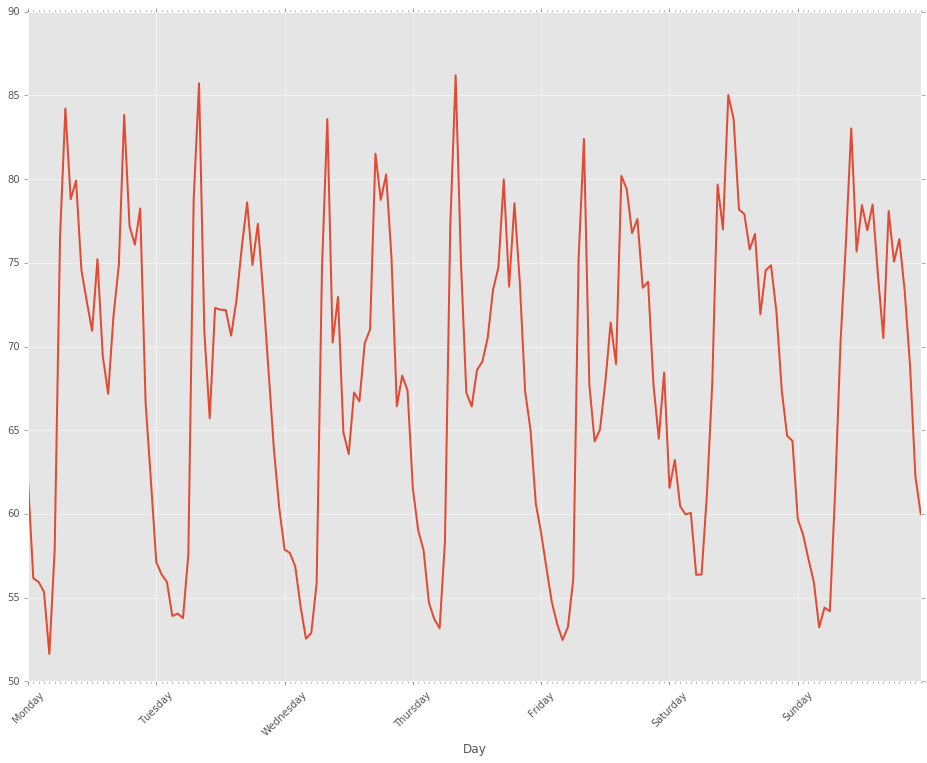

In [48]:
ax = df_g["value"].plot(lw=2)
ax.set_xticks(range(0, len(df_g.index), 24))
ax.set_xticks(range(0, len(df_g.index)), minor=True)
ax.set_xticklabels(weekdays, rotation=45)
ax.set_xlabel("Day")

In [49]:
df_g['value'].unstack(level=0)

dow,0,1,2,3,4,5,6
hour,,,,,,,
0,62.071090,57.135786,57.877141,61.509604,58.844620,61.558264,59.693382
1,56.157634,56.388731,57.665683,59.014439,56.738868,63.227175,58.751527
2,55.939130,55.939843,56.868889,57.839847,54.714605,60.453965,57.303189
3,55.342769,53.905217,54.459600,54.707598,53.420023,59.979499,55.932652
4,51.635607,54.051565,52.550096,53.720219,52.470499,60.062237,53.223140
5,57.854207,53.776963,52.891861,53.172635,53.237225,56.367427,54.405416
6,76.504072,57.590426,55.859682,58.331524,56.088782,56.381894,54.185199
7,84.217079,78.789913,74.693088,77.253846,75.238483,61.170807,61.454882
8,78.798165,85.727072,83.588937,86.204449,82.400908,67.766539,70.290975


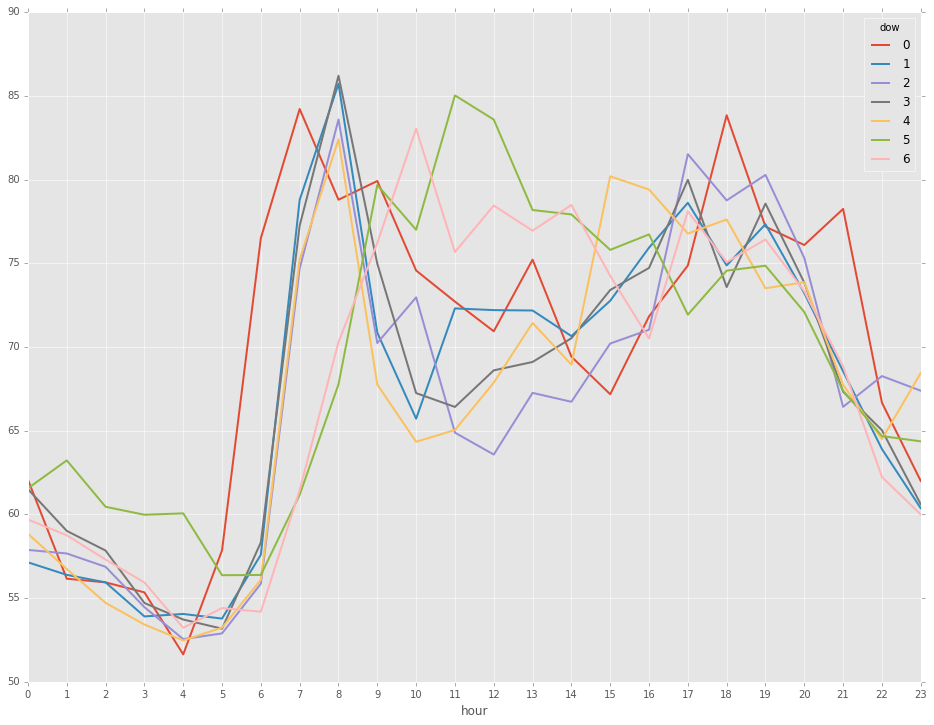

In [50]:
ax = df_g['value'].unstack(level=0).plot(lw=2)
ax.set_xticks(range(0, len(df_g.index) // 7))
#ax.set_xticklabels(weekdays, rotation=45)

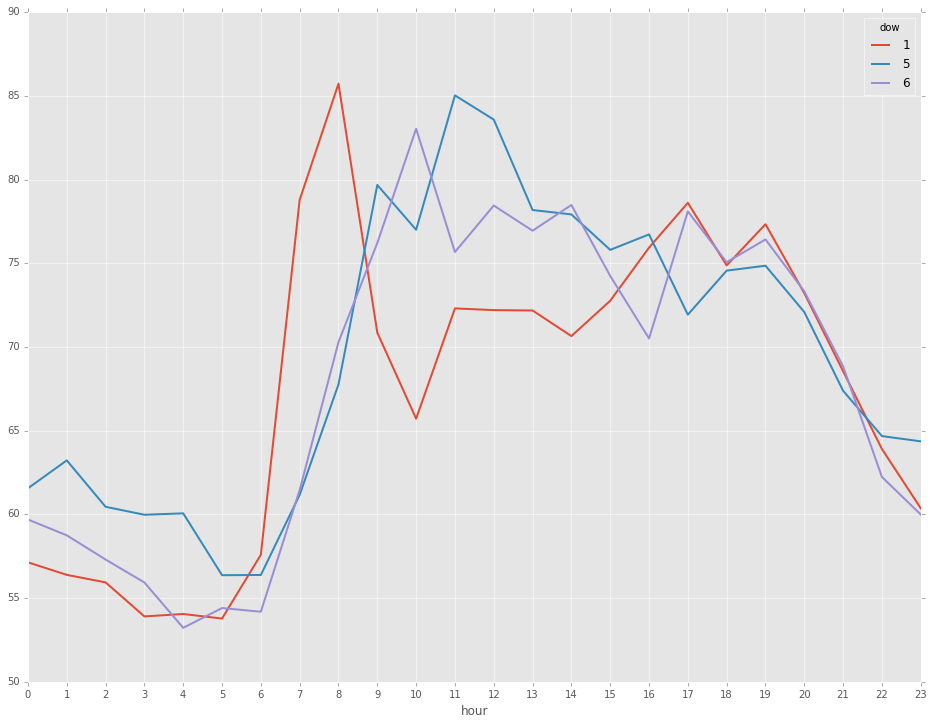

In [51]:
ax = df_g.loc[[1, 5, 6]]['value'].unstack(level=0).plot(lw=2)
ax.set_xticks(range(24))

### And over the course of a day?

In [52]:
# Sum of counts for all combinations
df_g_h = df[['value', 'hour']].groupby('hour').mean()

In [53]:
df_g_h

,value
hour,
0,59.870611
1,58.378108
2,57.090742
3,55.536897
4,54.122853
5,54.572159
6,59.868634
7,73.323679
8,79.444134


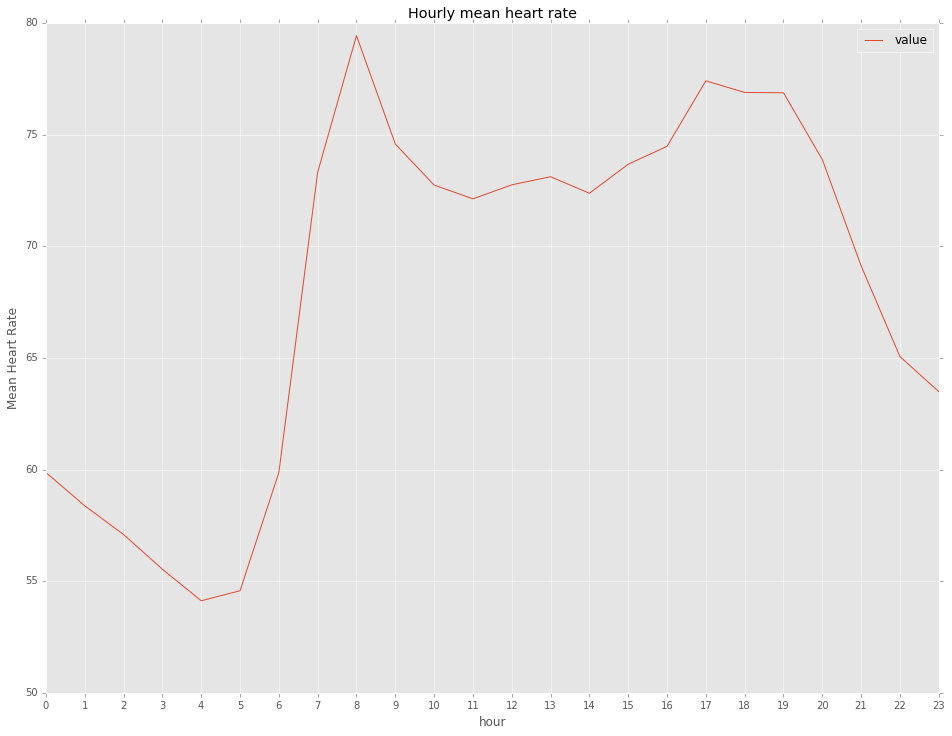

In [54]:
ax = df_g_h.plot()
ax.set_xticks(range(0, 24))
ax.set_title("Hourly mean heart rate")
ax.set_ylabel("Mean Heart Rate")